In [1]:
#importing relevant libraries

import pandas as pd
import numpy as np
import datetime
from datetime import date
import holidays
import warnings
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [2]:
# importing wait time data
colNames = ('CBSA Office', 'Location', 'Updated', 'Commercial Flow', 'Travellers Flow')
wait_time_df = pd.DataFrame(columns = colNames)

for subdir, dirs, files in os.walk("../data/wait time/"):
    for file in files:
        df = pd.read_csv(f'{subdir}{file}')
        if df.columns[4] != 'Travellers Flow':
            df = df.rename(columns = {df.columns[4]:'Travellers Flow'})
        wait_time_df = wait_time_df.merge(df, how='outer')        

In [3]:
# filteration of data to get data of Peace Bridge and Travellers flow only
peace_bridge_df = (wait_time_df.loc[wait_time_df['CBSA Office'] == 'Peace Bridge'])
peace_bridge_df = peace_bridge_df.reset_index(drop = True)
peace_bridge_df = peace_bridge_df.drop(columns ='Commercial Flow', axis = 1)

In [4]:
# dropping duplicates that incurred while merging data files(during import)
peace_bridge_df = peace_bridge_df.drop_duplicates()

In [5]:
# dropping rows that contain wait time for travellers flow as Missed entry
peace_bridge_df = peace_bridge_df[-peace_bridge_df['Travellers Flow'].isin(['Missed entry'])]

In [6]:
# importing weather data
data2 = pd.read_csv("../data/weather_data.csv")

In [7]:
# filtering data to get date and weather type only
weather_data = data2[['DATE', 'HourlyPresentWeatherType']]

In [8]:
# dropping null values
weather_data = weather_data.dropna(axis = 0, how = 'any')

In [9]:
# changing the type of column as datetime
weather_data['DATE'] = weather_data['DATE'].astype('datetime64[h]')
peace_bridge_df['Updated'] = peace_bridge_df['Updated'].astype('datetime64[h]')

In [10]:
# dropping duplicates for merging the two data sets
weather_data = weather_data.drop_duplicates(subset='DATE', keep="first")

In [11]:
weather_data = weather_data.rename(columns={'DATE': 'Updated'})

In [12]:
peace_bridge_and_weather_merged = peace_bridge_df.merge(weather_data, on='Updated', how='inner')

In [13]:
# importing weather codes data
weather_codes = pd.read_csv("../data/weather_codes.csv")

In [14]:
# creating a dictionary of weather codes
weather_dict = dict(zip(weather_codes['weather_code'], weather_codes['weather_type']))

In [15]:
# function to pick the weather code from the weather type column
def parse_weather(weather_string):
    tok = weather_string.split('|')
    tok = [i.strip() for i in tok]
    for section in tok:
        if section != '':
            tok_2 = section.split(' ')
            for symbol in tok_2:
                symbol  = symbol[1:] if symbol.startswith(('-', '+')) else symbol
                if symbol in weather_dict:
                    return symbol
    return np.nan

In [16]:
# calling the above function to get the code for weather_type
peace_bridge_and_weather_merged['HourlyPresentWeatherType'] = peace_bridge_and_weather_merged['HourlyPresentWeatherType'].apply(parse_weather)
peace_bridge_and_weather_merged = peace_bridge_and_weather_merged.dropna(axis = 0, how = 'any')

In [17]:
# renaming weather column
peace_bridge_and_weather_merged = peace_bridge_and_weather_merged.rename(columns={'HourlyPresentWeatherType': 'Weather_Type'})

In [18]:
# Extracting Date
peace_bridge_and_weather_merged['Date'] = pd.to_datetime(peace_bridge_and_weather_merged['Updated']).dt.date

# Days Names of the days
peace_bridge_and_weather_merged['Date'] = peace_bridge_and_weather_merged['Date'].astype('datetime64[ns]')
peace_bridge_and_weather_merged['Days'] = peace_bridge_and_weather_merged['Date'].dt.weekday_name

# Day Status of the days in week
peace_bridge_and_weather_merged['DayStatus'] = peace_bridge_and_weather_merged['Date'].dt.weekday
days = {0:'Weekday',1:'Weekday',2:'Weekday',3:'Weekday',4:'Weekday',5:'Weekend',6:'Weekend'}
peace_bridge_and_weather_merged['DayStatus'] = peace_bridge_and_weather_merged['DayStatus'].apply(lambda x:days[x])
                                                                
# Extracting year
peace_bridge_and_weather_merged['Year'] = pd.DatetimeIndex(peace_bridge_and_weather_merged['Updated']).year

# Extracting hour
peace_bridge_and_weather_merged['TimeHour'] = pd.to_datetime(peace_bridge_and_weather_merged['Updated']).dt.hour

In [19]:
peace_bridge_and_weather_merged.head()

,CBSA Office,Location,Updated,Travellers Flow,Weather_Type,Date,Days,DayStatus,Year,TimeHour
0,Peace Bridge,"Fort Erie, ON",2014-04-04 12:00:00,No Delay,RA:02,2014-04-04,Friday,Weekday,2014,12
1,Peace Bridge,"Fort Erie, ON",2014-04-04 11:00:00,No Delay,RA:02,2014-04-04,Friday,Weekday,2014,11
2,Peace Bridge,"Fort Erie, ON",2014-04-04 11:00:00,No Delay,RA:02,2014-04-04,Friday,Weekday,2014,11
4,Peace Bridge,"Fort Erie, ON",2014-04-04 00:00:00,No Delay,RA:02,2014-04-04,Friday,Weekday,2014,0
5,Peace Bridge,"Fort Erie, ON",2014-03-30 07:00:00,No Delay,SN:03,2014-03-30,Sunday,Weekend,2014,7


In [20]:
# Changing No Delay entries in WaitTime Column
peace_bridge_and_weather_merged['Travellers Flow'] = np.where(peace_bridge_and_weather_merged['Travellers Flow'] == 'No delay', 'No Delay', peace_bridge_and_weather_merged['Travellers Flow'])

In [47]:
peace_bridge_and_weather_merged['Wait_Time'] = np.where(peace_bridge_and_weather_merged['Travellers Flow'] == 'No Delay', 0, peace_bridge_and_weather_merged['Travellers Flow'])
peace_bridge_and_weather_merged['Wait_Time'] = peace_bridge_and_weather_merged['Wait_Time'].astype('int32')
# descriptive statistics of dataset
peace_bridge_and_weather_merged.describe()

,Year,TimeHour,Wait_Time,TravellerLogit
count,40841.000000,40841.000000,40841.000000,40841.000000
mean,2014.604099,11.169389,1.332289,0.031904
std,1.559211,7.178114,3.508725,0.175747
min,2010.000000,0.000000,0.000000,0.000000
25%,2015.000000,5.000000,0.000000,0.000000
50%,2015.000000,11.000000,0.000000,0.000000
75%,2015.000000,18.000000,1.000000,0.000000
max,2017.000000,23.000000,75.000000,1.000000


count    40841.000000
mean         1.332289
std          3.508725
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         75.000000
Name: Wait_Time, dtype: float64


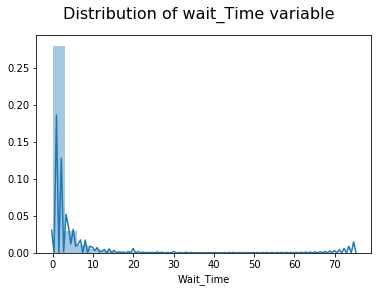

In [22]:
# EDA- looking at the distribution of Wait time
import seaborn as sns

print(peace_bridge_and_weather_merged['Wait_Time'].describe())
plt.figure()
sns.distplot(peace_bridge_and_weather_merged['Wait_Time'], bins=25, hist_kws={'alpha': 0.4})
plt.suptitle('Distribution of wait_Time variable', fontsize=16)
plt.show()

In [23]:
# WaitTime column for Logistic Regression
peace_bridge_and_weather_merged['TravellerLogit'] = np.where(peace_bridge_and_weather_merged['Wait_Time']<10, 0, 1)


0    39538
1     1303
Name: TravellerLogit, dtype: int64


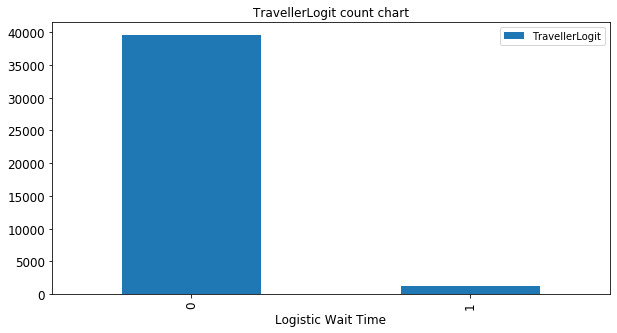

In [49]:
# TravellerLogit count chart
import matplotlib.pyplot as plt
TravellerLogit_count = peace_bridge_and_weather_merged['TravellerLogit'].value_counts()
print(TravellerLogit_count)
ax = TravellerLogit_count.plot(kind='bar', title ="TravellerLogit count chart", figsize=(10, 5), legend=True, fontsize=12)
ax.set_xlabel("Logistic Wait Time", fontsize=12)
plt.show()

In [25]:
# Splitting the data into 2 parts as 2010-2016 (training period) & 2017 (testing period)
is_2017 = peace_bridge_and_weather_merged['Year'] == 2017
final_df_2017 = peace_bridge_and_weather_merged[is_2017]
final_df_2017.head()

,CBSA Office,Location,Updated,Travellers Flow,Weather_Type,Date,Days,DayStatus,Year,TimeHour,Wait_Time,TravellerLogit
44900,Peace Bridge,"Fort Erie, ON",2017-01-02 16:00:00,19,RA:02,2017-01-02,Monday,Weekday,2017,16,19,1
44901,Peace Bridge,"Fort Erie, ON",2017-01-02 16:00:00,13,RA:02,2017-01-02,Monday,Weekday,2017,16,13,1
44902,Peace Bridge,"Fort Erie, ON",2017-01-02 16:00:00,15,RA:02,2017-01-02,Monday,Weekday,2017,16,15,1
44903,Peace Bridge,"Fort Erie, ON",2017-01-03 08:00:00,No Delay,RA:02,2017-01-03,Tuesday,Weekday,2017,8,0,0
44904,Peace Bridge,"Fort Erie, ON",2017-01-03 09:00:00,No Delay,RA:02,2017-01-03,Tuesday,Weekday,2017,9,0,0


In [26]:
is_2010_to_2016 =  [not i for i in is_2017]
final_df_2010_to_2016 = peace_bridge_and_weather_merged[is_2010_to_2016]

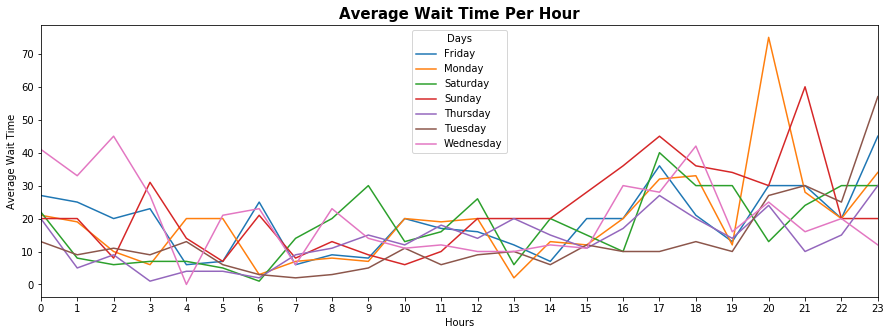

In [64]:
# 2010-2016 data
# plotting figure showing days and hours in a day for wait time data
fig, ax = plt.subplots(figsize=(15,5))
Traveller_avg_waitTime = final_df_2010_to_2016.groupby(["TimeHour", "Days"])['Wait_Time'].max().unstack().plot(ax=ax)
plt.ylabel('Average Wait Time', fontsize = 10)
plt.xlabel('Hours', fontsize = 10)
plt.title('Average Wait Time Per Hour',x=0.5, y=1,fontsize =15,fontweight="bold")
hour_ticks = np.arange(0, 24, 1)
ax.set_xticks(hour_ticks)
plt.show()

In [28]:
# function to pick the weather code from the weather type column using the graph above
def get_hour_status(time):
    if time >= 0 and time <= 3:
        return 'night'
    elif time >= 4 and time <= 9:
        return 'morning'
    elif time >= 10 and time <= 15:
        return 'afternoon'
    elif time >= 16 and time <= 21:
        return 'evening'
    elif time >= 22 and time <= 23:
        return 'night'
    else:
        raise Exception(f'Invalid time = {time}')

In [29]:
# calling the funtcion above
final_df_2010_to_2016['Hour_status'] = final_df_2010_to_2016['TimeHour'].apply(get_hour_status)
final_df_2017['Hour_status'] = final_df_2017['TimeHour'].apply(get_hour_status)

In [30]:
# checking the counts of entries of weather types
final_df_2010_to_2016['Weather_Type'].value_counts()

SN:03    19025
RA:02    10476
BR:1      6058
DZ:01     1283
HZ:7       774
FG:2       274
FU:3        23
PL:06       18
GS:08        5
SQ:2         2
Name: Weather_Type, dtype: int64

In [31]:
# Removing weather types with insufficient data
final_df_2010_to_2016 = final_df_2010_to_2016[~final_df_2010_to_2016['Weather_Type'].isin(['SQ:2', 'GS:08', 'PL:06', 'FU:3'])]
final_df_2017 = final_df_2017[~final_df_2017['Weather_Type'].isin(['SQ:2', 'GS:08', 'PL:06', 'FU:3'])]

              Wait_Time
Weather_Type           
BR:1           0.990591
DZ:01          1.371005
FG:2           0.510949
HZ:7           1.054264
RA:02          1.755155
SN:03          0.703443


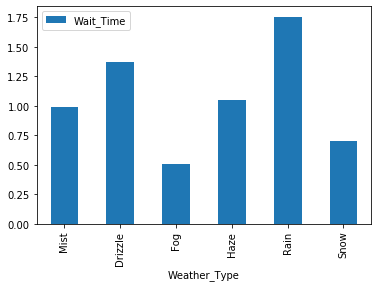

In [32]:
# comparing the average wait time during different weather types
print(final_df_2010_to_2016[['Weather_Type', 'Wait_Time']].groupby(['Weather_Type']).mean())
weather_average_wait_time = final_df_2010_to_2016[['Weather_Type', 'Wait_Time']].groupby(['Weather_Type']).mean().plot(kind='bar')
weather_average_wait_time.set_xticklabels(('Mist', 'Drizzle', 'Fog', 'Haze', 'Rain', 'Snow'))
plt.show()

In [33]:
# Regression analysis
# Applying OneHotEncoding using get_dummies from pandas
dummies_df_2010_to_2016 = pd.get_dummies(final_df_2010_to_2016, columns=['Hour_status', 'Weather_Type'])
dummies_df_2017 = pd.get_dummies(final_df_2017, columns=['Hour_status', 'Weather_Type'])

In [34]:
# #filtering only numerical values for modeling
# dummy_var_num = dummies_df_2010_to_2016.select_dtypes(include = ['uint8','int32', 'int64'])
# #correlation and printing only head
# dummy_var_corr = dummy_var_num.corr()['Wait_Time']
# dummy_var_corr

In [35]:
# choosing the columns for x variables for training the model
target_columns = []
for col in dummies_df_2010_to_2016.columns:
    if col.startswith('Hour_status_') or col.startswith('Weather_Type_'):
        target_columns.append(col)
print(target_columns)

['Hour_status_afternoon', 'Hour_status_evening', 'Hour_status_morning', 'Hour_status_night', 'Weather_Type_BR:1', 'Weather_Type_DZ:01', 'Weather_Type_FG:2', 'Weather_Type_HZ:7', 'Weather_Type_RA:02', 'Weather_Type_SN:03']


In [36]:
# creating x & y variables for training and testing of models for both the datasets
X_train_2010_to_2016 = dummies_df_2010_to_2016.loc[:, target_columns]
y_train_2010_to_2016 = dummies_df_2010_to_2016.loc[:,['TravellerLogit']]
X_test_2017 = dummies_df_2017.loc[:, target_columns]
y_test_2017 = dummies_df_2017.loc[:,['TravellerLogit']]

In [51]:

os = SMOTE(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train_2010_to_2016.columns
os_data_X, os_data_y=os.fit_sample(X_train_2010_to_2016, y_train_2010_to_2016)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y, columns=['TravellerLogit'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['TravellerLogit']==0]))
print("Number of subscription",len(os_data_y[os_data_y['TravellerLogit']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['TravellerLogit']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['TravellerLogit']==1])/len(os_data_X))

Length of oversampled data is  74022
Number of no subscription in oversampled data 37011
Number of subscription 37011
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [52]:
# training the logistic model
logistic_reg = LogisticRegression()
logistic_reg.fit(os_data_X, os_data_y)

LogisticRegression()

In [53]:
print(logistic_reg.coef_)
print(logistic_reg.intercept_)

[[1.84670296 2.87057454 0.39445646 1.93627102 2.02961899 2.3562689
  0.20712074 1.56192448 3.04619541 2.1696095 ]]
[-4.53324031]


In [54]:
# predicting/testing the data for 2017 based on the model & getting the accuracy score
y_pred_2017 = logistic_reg.predict(X_test_2017)
print('Accuracy of logistic regression on test set of 2017: {:.2f}'.format(logistic_reg.score(X_test_2017, y_test_2017)))

Accuracy of logistic regression on test set of 2017: 0.55


In [55]:
from sklearn.metrics import confusion_matrix
# creating a confusion matrix to check for false/true positives/negatives
confusion_matrix = confusion_matrix(y_test_2017, y_pred_2017)
print(confusion_matrix)

[[1287 1190]
 [ 127  297]]


In [56]:
# extracting the summary report for the model
print(classification_report(y_test_2017, y_pred_2017))

              precision    recall  f1-score   support

           0       0.91      0.52      0.66      2477
           1       0.20      0.70      0.31       424

    accuracy                           0.55      2901
   macro avg       0.55      0.61      0.49      2901
weighted avg       0.81      0.55      0.61      2901



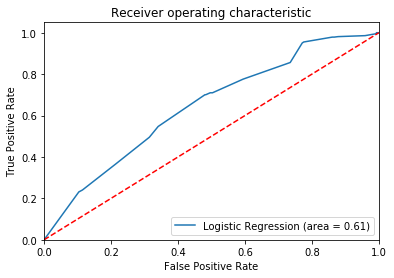

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_2017, logistic_reg.predict(X_test_2017))
fpr, tpr, thresholds = roc_curve(y_test_2017, logistic_reg.predict_proba(X_test_2017)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()